In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
print('torch version :', torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('torch device :',device)

torch version : 1.7.1
torch device : cuda:0


In [2]:
train_data = datasets.MNIST(root='data',train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='data',train=False, transform=transforms.ToTensor(), download=True)

In [3]:
train_data.__getitem__(0)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

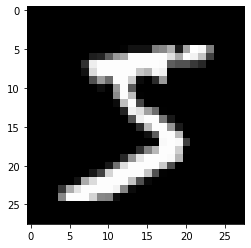

In [4]:
plt.imshow(train_data.__getitem__(0)[0].reshape(28,28),cmap='gray')
plt.show()

In [5]:
BATCH_SIZE = 256
train_iter = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=1)
test_iter = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, num_workers=1)

In [6]:
class NLP(nn.Module):
    def __init__(self, x_dim=28*28, h_dim=256, y_dim=10):
        super(NLP, self).__init__()
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.y_dim = y_dim
        self.lin_1 = nn.Linear(self.x_dim, self.h_dim)
        self.lin_2 = nn.Linear(self.h_dim, self.y_dim)
        self.init_param()
        
    def forward(self,x):
        x = self.lin_2(F.relu(self.lin_1(x)))
        return x
    
    def init_param(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        

In [7]:
model = NLP(x_dim = 28*28,h_dim = 256, y_dim=10).to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)

- Parameter check

In [8]:
for name, param in model.named_parameters():
    num_param = param.detach().cpu().numpy().reshape(-1)[:3]
    print(name, num_param)

lin_1.weight [ 0.02628374  0.02354652 -0.02636467]
lin_1.bias [0. 0. 0.]
lin_2.weight [-0.01812312  0.16334656 -0.11457732]
lin_2.bias [0. 0. 0.]


- data

In [9]:
def eval_func(model, data_iter, device):
    model.eval()
    with torch.no_grad():
        count_all, count = 0,0
        for batch_in, batch_label in data_iter:
            x = batch_in.view(-1,28*28).to(device)
            y = batch_label.to(device)
            y_pred = model.forward(x)
            _, y_ = torch.max(y_pred,dim=-1)
            count_all += batch_in.size(0)
            count += ((y == y_).sum().item())
    return count/count_all

In [10]:
eval_func(model, train_iter, device)

0.16808333333333333

In [11]:
eval_func(model, test_iter, device)

0.1724

통계적으로 확률적으로 높은 것들을 찾는 것이 아니라 인과관계를 찾아야 할텐데..

In [12]:
EPOCH = 10
for i in range(EPOCH):
    model.train()
    for batch_in, batch_label in train_iter:
        x = batch_in.view(-1,28*28).to(device)
        y = batch_label.to(device)
        y_pred = model.forward(x)
        loss_out = loss(y_pred,y)
        optimizer.zero_grad()
        loss_out.backward()
        optimizer.step()
    train_eval = eval_func(model, train_iter, device)
    test_eval = eval_func(model, test_iter, device)
    print(i, train_eval, test_eval, loss_out.data)

0 0.9283666666666667 0.926 tensor(0.1575, device='cuda:0')
1 0.9499166666666666 0.9485 tensor(0.2611, device='cuda:0')
2 0.9609 0.9566 tensor(0.3085, device='cuda:0')
3 0.9680166666666666 0.9625 tensor(0.0743, device='cuda:0')
4 0.9725833333333334 0.9665 tensor(0.0414, device='cuda:0')
5 0.9779833333333333 0.9711 tensor(0.1212, device='cuda:0')
6 0.9812666666666666 0.9719 tensor(0.0741, device='cuda:0')
7 0.9843666666666666 0.9733 tensor(0.0582, device='cuda:0')
8 0.9860666666666666 0.9751 tensor(0.0857, device='cuda:0')
9 0.9876 0.9759 tensor(0.0466, device='cuda:0')


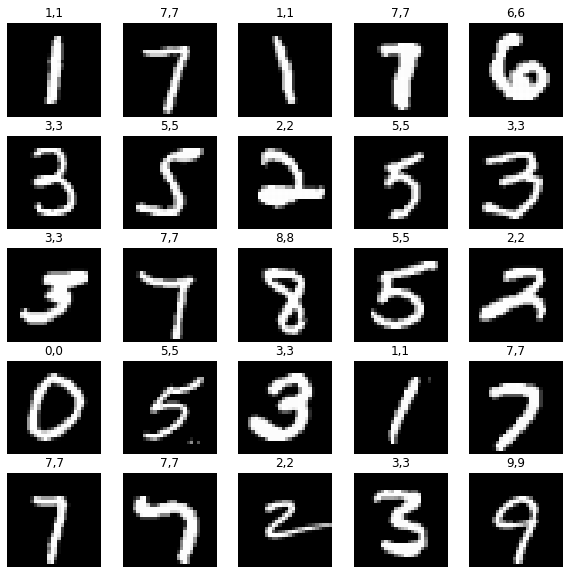

In [46]:
choice_num = 25
choice_index = np.random.choice(60000,choice_num,replace=False)
x = train_data.data[choice_index]
y = train_data.targets[choice_index]
with torch.no_grad():
    model.eval()
    y_pred = model.forward(x.view(-1,28*28).type(torch.float).to(device))
_, y_ = torch.max(y_pred,dim=-1)
fig = plt.figure(figsize=(10,10))
for i in range(choice_num):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(x[i],cmap='gray')
    plt.title(f'{y_[i]},{y[i].item()}')